# Points of Dispense - Flood
Maxwell Kennady, Nora Murray, Elizabeth Speigle

In [42]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Optimization

Read in data from files

In [43]:
distances = pd.read_csv('data/OD_Pairs_Distances.csv')
population = pd.read_excel('data/BG_master.xlsx')
bg_included = pd.read_csv('data/bg_pop_included.csv')
pod_data = pd.read_csv('data/POD_ids.csv')

In [44]:
dist_miles = distances.pivot(index='block_group', columns='pod_id', values='Miles')
dist_time = distances.pivot(index='block_group', columns='pod_id', values='TravelTime')

In [45]:
dist = dist_miles.values
N = population['population'].values
prop = population['flood'].values

In [46]:
population[population['flood']==1].head()

,bg_id,census_geo_id,statefp,countyfp,tractce,blkgrpce,latitude,longitude,population,num_hhs,hh_no_car,hh_car,flood
295,296,1500000US420034011002,42,3,401100,2,40.637146,-79.707663,1743,597,27,570,1
296,297,1500000US420034011003,42,3,401100,3,40.627984,-79.715253,841,390,35,355,1
298,299,1500000US420034012001,42,3,401200,1,40.614790,-79.721640,390,174,9,165,1
300,301,1500000US420034012003,42,3,401200,3,40.611475,-79.723985,647,286,25,261,1
304,305,1500000US420034013003,42,3,401300,3,40.616679,-79.740132,1035,341,0,341,1


Create indices for block groups and PODs

In [47]:
blocks = range(len(N))
pods = range(len(dist[0]))

Initialize model for POD locations

In [48]:
m = gp.Model('POD_locations')

Add decision variables x[i] for whether a POD is opened and y[i,j] for whether POD i serves block group j

In [49]:
x = m.addVars(pods, vtype=GRB.BINARY, name='x')
y = m.addVars(blocks, pods, vtype=GRB.BINARY, name='x')

Set up objective function to minimize total distance across the population

In [50]:
obj = gp.quicksum(dist[j,i] * x[i] * y[j, i] * N[j] * prop[j] 
                  for j in blocks for i in pods)
m.setObjective(obj, GRB.MINIMIZE)

Constraint: y[i,j] can only be 1 if x[i] is also 1, meaning POD i is opened

In [51]:
m.addConstrs((y[j, i] <= x[i] for i in pods for j in blocks), name='y_if_x')

{(0, 0): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 2): <gurobi.Constr *Awaiting Model Update*>,
 (0, 3): <gurobi.Constr *Awaiting Model Update*>,
 (0, 4): <gurobi.Constr *Awaiting Model Update*>,
 (0, 5): <gurobi.Constr *Awaiting Model Update*>,
 (0, 6): <gurobi.Constr *Awaiting Model Update*>,
 (0, 7): <gurobi.Constr *Awaiting Model Update*>,
 (0, 8): <gurobi.Constr *Awaiting Model Update*>,
 (0, 9): <gurobi.Constr *Awaiting Model Update*>,
 (0, 10): <gurobi.Constr *Awaiting Model Update*>,
 (0, 11): <gurobi.Constr *Awaiting Model Update*>,
 (0, 12): <gurobi.Constr *Awaiting Model Update*>,
 (0, 13): <gurobi.Constr *Awaiting Model Update*>,
 (0, 14): <gurobi.Constr *Awaiting Model Update*>,
 (0, 15): <gurobi.Constr *Awaiting Model Update*>,
 (0, 16): <gurobi.Constr *Awaiting Model Update*>,
 (0, 17): <gurobi.Constr *Awaiting Model Update*>,
 (0, 18): <gurobi.Constr *Awaiting Model Update*>,
 (0, 19): <gurobi.Constr *Awaiting Model 

Constraint: each block group must be assigned one shelter

In [52]:
m.addConstrs((gp.quicksum(y[j, i] for i in pods) == 1
             for j in blocks), name='all_blocks_assigned')

{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>,
 21: <gurobi.Constr *Awaiting Model Update*>

Constraint: number of PODs opened must be ...

In [53]:
m.addConstr((gp.quicksum(x[i] for i in pods) <= 20), name='pods_opened')

<gurobi.Constr *Awaiting Model Update*>

Optimize model

In [54]:
m.optimize()

Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (win64)
Optimize a model with 52801 rows, 51747 columns and 155147 nonzeros
Model fingerprint: 0x02ae907c
Model has 1880 quadratic objective terms
Variable types: 0 continuous, 51747 integer (51747 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e+02, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve time: 0.16s
Presolved: 54681 rows, 53627 columns, 160787 nonzeros
Variable types: 0 continuous, 53627 integer (53627 binary)
Found heuristic solution: objective 937627.41436

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relaxation: objective 0.000000e+00, 4163 iterations, 0.12 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

 

### Analysis

Which block groups were assigned to which shelters?

In [55]:
block_pod_list = [[j,i] for j in blocks for i in pods if (y[j, i].x==1) & (prop[j]==1)]

In [56]:
block_pod_list

[[295, 17],
 [296, 17],
 [298, 17],
 [300, 17],
 [304, 17],
 [308, 17],
 [309, 17],
 [310, 17],
 [311, 17],
 [312, 17],
 [313, 17],
 [314, 38],
 [370, 16],
 [380, 38],
 [381, 38],
 [385, 38],
 [386, 38],
 [387, 38],
 [388, 38],
 [390, 14],
 [404, 14],
 [405, 14],
 [407, 29],
 [408, 34],
 [814, 35],
 [937, 26],
 [938, 31],
 [944, 33],
 [947, 33],
 [948, 33],
 [949, 33],
 [950, 33],
 [951, 33],
 [952, 33],
 [954, 31],
 [957, 31],
 [958, 31],
 [959, 31],
 [960, 31],
 [962, 31]]

In [ ]:
# pods_flood_20 = open('pods_flood_20','wb') 
# pickle.dump(block_pod_list, pods_flood_20)                      
# pods_flood_20.close()

In [58]:
dist_min_total = [N[j] * [dist[j,i]] for [j,i] in block_pod_list]
dist_min_total_flat = [item for sublist in dist_min_total for item in sublist]

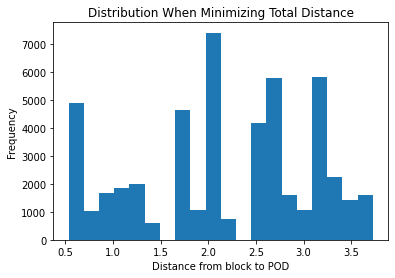

In [65]:
plt.hist(dist_min_total_flat, bins=20)
plt.title('Distribution When Minimizing Total Distance')
plt.xlabel('Distance from block to POD')
plt.ylabel('Frequency')
plt.show()

In [60]:
capacity_pod_all = [[N[j], i] for [j,i] in block_pod_list]

In [61]:
capacity_pod = {}
for [N, i] in capacity_pod_all:
    if i not in capacity_pod:
        capacity_pod[i] = N
    else:
        capacity_pod[i] += N

In [62]:
max(capacity_pod.values())

12842

In [63]:
min(capacity_pod.values())

551

In [64]:
capacity_pod

{17: 9702,
 38: 7778,
 16: 2490,
 14: 3434,
 29: 770,
 34: 551,
 35: 1150,
 26: 1887,
 31: 12842,
 33: 8921}